In [2]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai as genai
import anthropic

In [3]:
# Load environment variables in a file called .env

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "your-key-if-not-using-env")
os.environ["ANTHROPIC_API_KEY"] = os.getenv(
    "ANTHROPIC_API_KEY", "your-key-if-not-using-env"
)
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY", "your-key-if-not-using-env")

In [4]:
system_message = "You are a helpful assistant that analyzes the content of an article and provides a summary in markdown."
prompt = "Please provide a short summary of the article in markdown format."

In [6]:
# Connect to OpenAI, Anthropic and Google

openai = OpenAI()

claude = anthropic.Anthropic()

genai.configure()

In [20]:
# Let's wrap a call to GPT-4o-mini in a simple function

def summarize_gpt(prompt=prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt},
    ]
    response = openai.chat.completions.create(
        model="gpt-4o-mini", messages=messages, stream=False
    )
    return response.choices[0].message.content

In [30]:
def summarize_claude(article_text):
    """
    Sends an article to the Anthropic API to generate a summary.
    
    Parameters:
    article_text (str): The full text of the article to be summarized.
    
    Returns:
    str: The summary of the article generated by the Anthropic API.
    """
    
    system_message = """
    You are an AI assistant tasked with summarizing articles. Your goal is to provide a concise, accurate, and informative summary of the key points in the given article text. Focus on capturing the main ideas, key findings, and important conclusions. Avoid including unnecessary details or tangents. The summary should be approximately 1-2 paragraphs in length.
    """
    
    try:
        response = claude.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1000,
            system = system_message,
            messages = [
                {"role": "user", "content": article_text}
            ]
        )
        return response.content[0].text
    except Exception as e:
        raise Exception(f"Error summarizing article: {e}")

In [42]:
def gemini(prompt=prompt):
    gemini = genai.GenerativeModel(
    model_name='gemini-1.5-flash',
    system_instruction=system_message
    )
    response = gemini.generate_content(prompt)
    return response.candidates[0].content.parts[0].text

In [10]:
import pandas as pd

# Read a sample article from a CSV file
df = pd.read_csv("articles.csv")
df.head()

,article_id,full_text,ABSTRACT
0,PMC11221914,Cognitive Symptoms in Cross-Sectional Parkinso...,Background and Objectives Cognitive impairment...
1,PMC11034606,Potential role of hippocampal neurogenesis in ...,It has been reported both in clinic and rodent...
2,PMC11034585,Metabolic reprogramming of the inflammatory re...,Metabolism is a fundamental process by which b...
3,PMC11034587,Efficacy of exercise rehabilitation for managi...,Alzheimer’s disease (AD) is a progressive and ...
4,PMC11034592,Unraveling the gut-brain axis: the impact of s...,This comprehensive review explores the intrica...


In [46]:
# Select the first article
article = df["full_text"][0]
abstract = df["ABSTRACT"][0]

In [22]:
openai_response = summarize_gpt(article)
print(openai_response)

# Summary of Cognitive Symptoms in Cross-Sectional Parkinson Disease Cohort

## Introduction
Cognitive impairment in Parkinson Disease (PD) is varied and significantly impacts the quality of life for patients and their care partners. Existing knowledge about cognition in PD primarily comes from cognitive screening tools, with cognitive deficits observable even in early disease stages. This study employs machine learning and natural language processing to classify self-reported cognitive symptoms from over 25,000 PD patients through the PD-Patient Report of Problems (PD-PROP).

## Methods
- **Study Design**: The Fox Insight study received approval from New England IRB, and informed consent was collected online.
- **Data Collection**: Participants reported their most bothersome PD problems every three months through the PD-PROP.
- **Curation Process**: Symptoms were identified from patient verbatim responses, culminating in the classification of eight cognitive symptoms: memory, attentio

In [31]:
# Use the Anthropic API to summarize the article
anthropic_response = summarize_claude(article)
print(anthropic_response)

Here is a summary of the key points from the article:

The article examines the cognitive symptoms experienced by patients with Parkinson's disease (PD) using a large cohort of over 25,000 participants from the Fox Insight study. Researchers used natural language processing and machine learning to analyze free-text responses from patients on their most bothersome problems due to PD.

Key findings:
- Nearly one-third of participants reported cognitive symptoms as a most bothersome problem, including 14% within the first year after PD diagnosis. The most frequent cognitive complaints were memory, language/word finding, and concentration/attention.
- Demographic and disease factors associated with reporting cognitive problems included depression, higher motor disability, and higher education level, but not age.
- Older patients were more likely to report posterior cortical cognitive symptoms (e.g. visuospatial, memory, language) compared to younger patients who reported more frontostriata

In [43]:
# Use the Google Generative AI API to summarize the article
gemini_response = gemini(article)
print(gemini_response)

## Cognitive Symptoms in Parkinson's Disease: A Large-Scale Analysis Using Natural Language Processing

This study, based on data from the Fox Insight cohort, explored the cognitive symptoms experienced by individuals with Parkinson's disease (PD). Using a novel approach combining human-in-the-loop curation, natural language processing, and machine learning, the researchers analyzed free-text responses from over 25,000 participants. This method allowed for a more comprehensive understanding of the spectrum of cognitive problems reported by patients compared to traditional methods using standardized questionnaires.

**Key Findings:**

* **Prevalence:** Nearly one-third of participants reported cognitive symptoms as a most bothersome problem, with memory, language, and concentration/attention being the most frequently reported.
* **Associations:**  Depression, higher MDS-UPDRS Part II score (indicating greater motor dysfunction), and higher education were associated with reporting cognit

In [44]:
import evaluate

In [47]:
rouge = evaluate.load("rouge")

# Evaluate the summaries generated by the different models
openai_scores = rouge.compute(predictions=[openai_response], references=[abstract])
print("OpenAI gemini-1.5-flash Scores:")
print(openai_scores)

OpenAI gemini-1.5-flash Scores:
{'rouge1': 0.4954545454545454, 'rouge2': 0.17767653758542143, 'rougeL': 0.23863636363636362, 'rougeLsum': 0.3568181818181818}


In [48]:
anthropic_scores = rouge.compute(predictions=[anthropic_response], references=[abstract])
print("Anthropic Scores:")
print(anthropic_scores)

Anthropic Scores:
{'rouge1': 0.4382207578253707, 'rouge2': 0.15867768595041323, 'rougeL': 0.24382207578253706, 'rougeLsum': 0.3064250411861615}


In [49]:
genai_scores = rouge.compute(predictions=[gemini_response], references=[abstract])
print("Google Generative AI Scores:")
print(genai_scores)

Google Generative AI Scores:
{'rouge1': 0.4690721649484536, 'rouge2': 0.1757105943152455, 'rougeL': 0.21649484536082475, 'rougeLsum': 0.30412371134020616}


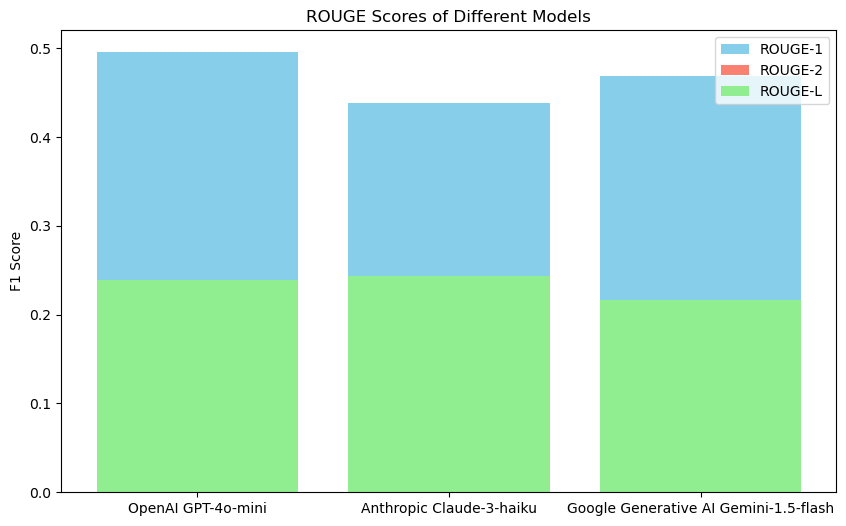

In [51]:
# Create a chart to compare the ROUGE scores of the different models

import matplotlib.pyplot as plt

models = ["OpenAI GPT-4o-mini", "Anthropic Claude-3-haiku", "Google Generative AI Gemini-1.5-flash"]

rouge_1_scores = [openai_scores["rouge1"], anthropic_scores["rouge1"], genai_scores["rouge1"]]
rouge_2_scores = [openai_scores["rouge2"], anthropic_scores["rouge2"], genai_scores["rouge2"]]
rouge_l_scores = [openai_scores["rougeL"], anthropic_scores["rougeL"], genai_scores["rougeL"]]

plt.figure(figsize=(10, 6))
plt.bar(models, rouge_1_scores, color="skyblue", label="ROUGE-1")
plt.bar(models, rouge_2_scores, color="salmon", label="ROUGE-2")
plt.bar(models, rouge_l_scores, color="lightgreen", label="ROUGE-L")
plt.ylabel("F1 Score")
plt.title("ROUGE Scores of Different Models")
plt.legend()
plt.show()

## To do: Fine-tuning LLM for our use case